# Janatahack: Cross-sell Prediction
[Link to competition here!](https://datahack.analyticsvidhya.com/contest/janatahack-cross-sell-prediction/)

Go there and register to be able to download the dataset and submit your predictions.Click the button below to open this notebook in Google Colab!

<a href="https://colab.research.google.com/github/jpraguer/jpraguer.github.io/master/_posts/ClassificationEDABaseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Cross-selling identifies products or services that satisfy additional, complementary needs that are unfulfilled by the original product that a customer possesses. As an example, a mouse could be cross-sold to a customer purchasing a keyboard. Oftentimes, cross-selling points users to products they would have purchased anyways; by showing them at the right time, a store ensures they make the sale.

Cross-selling is prevalent in various domains and industries including banks. For example, credit cards are cross-sold to people registering a savings account. In ecommerce, cross-selling is often utilized on product pages, during the checkout process, and in lifecycle campaigns. It is a highly-effective tactic for generating repeat purchases, demonstrating the breadth of a catalog to customers. Cross-selling can alert users to products they didn't previously know you offered, further earning their confidence as the best retailer to satisfy a particular need.

Your client is an Insurance company that has provided Health Insurance to its customers now they need your help in building a model to predict whether the policyholders (customers) from past year will also be interested in Vehicle Insurance provided by the company.

An insurance policy is an arrangement by which a company undertakes to provide a guarantee of compensation for specified loss, damage, illness, or death in return for the payment of a specified premium. A premium is a sum of money that the customer needs to pay regularly to an insurance company for this guarantee.

For example, you may pay a premium of Rs. 5000 each year for a health insurance cover of Rs. 200,000/- so that if, God forbid, you fall ill and need to be hospitalised in that year, the insurance provider company will bear the cost of hospitalisation etc. for upto Rs. 200,000. Now if you are wondering how can company bear such high hospitalisation cost when it charges a premium of only Rs. 5000/-, that is where the concept of probabilities comes in picture. For example, like you, there may be 100 customers who would be paying a premium of Rs. 5000 every year, but only a few of them (say 2-3) would get hospitalised that year and not everyone. This way everyone shares the risk of everyone else.

Just like medical insurance, there is vehicle insurance where every year customer needs to pay a premium of certain amount to insurance provider company so that in case of unfortunate accident by the vehicle, the insurance provider company will provide a compensation (called ‘sum assured’) to the customer.

Building a model to predict whether a customer would be interested in Vehicle Insurance is extremely helpful for the company because it can then accordingly plan its communication strategy to reach out to those customers and optimise its business model and revenue. 

Now, in order to predict, whether the customer would be interested in Vehicle insurance, you have information about demographics (gender, age, region code type), Vehicles (Vehicle Age, Damage), Policy (Premium, sourcing channel) etc.

In [1]:
# install catboost
!pip install catboost

     |████████████████████████████████| 65.8MB 49kB/s 


In [2]:
# import useful libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid") # set seaborn graphing style

import catboost
from catboost import *

In [3]:
# mount G-drive to get data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# load in data and set seed
BASE = "/content/drive/My Drive/JanataHack/Crossell/data/"
SEED = 2020

train_df = pd.read_csv(f"{BASE}train.csv")
test_df = pd.read_csv(f"{BASE}test.csv")
submit_df = pd.read_csv(f"{BASE}sample_submission.csv")

## EDA starts
First we look at the first few rows of all datasets.

In [5]:
train_df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [6]:
submit_df.head()

,id,Response
0,381110,0
1,381111,0
2,381112,0
3,381113,0
4,381114,0


In [7]:
# look at distribution of target variable
train_df["Response"].value_counts()

0    334399
1     46710
Name: Response, dtype: int64

In [8]:
# look at which variables are null and if they were parsed correctly
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


In [9]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127037 entries, 0 to 127036
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    127037 non-null  int64  
 1   Gender                127037 non-null  object 
 2   Age                   127037 non-null  int64  
 3   Driving_License       127037 non-null  int64  
 4   Region_Code           127037 non-null  float64
 5   Previously_Insured    127037 non-null  int64  
 6   Vehicle_Age           127037 non-null  object 
 7   Vehicle_Damage        127037 non-null  object 
 8   Annual_Premium        127037 non-null  float64
 9   Policy_Sales_Channel  127037 non-null  float64
 10  Vintage               127037 non-null  int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 10.7+ MB


No nulls, therefore no imputation needed! For examples of imputation, please check out my other templates!

### Looking at categorical columns
Because of all the categorical columns I decided to set a baseline in Catboost. Here are value counts and countplots for all of them, they prove useful to gauge relationship with the target column (if any).

In [10]:
train_df["Gender"].value_counts()

Male      206089
Female    175020
Name: Gender, dtype: int64

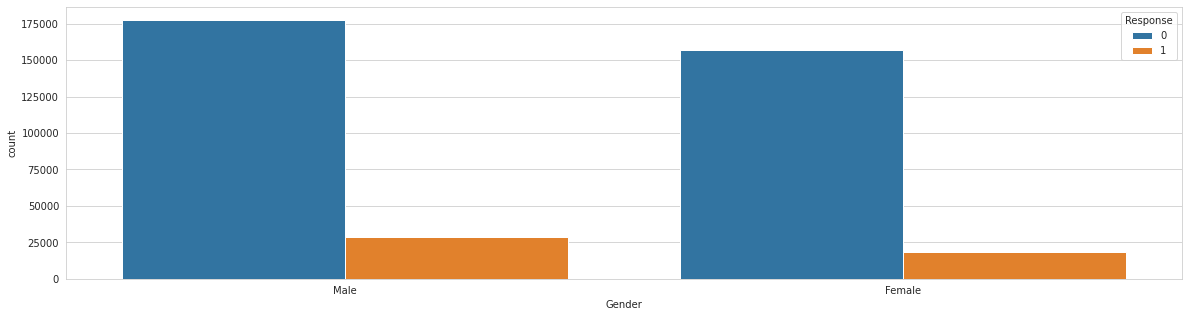

In [11]:
plt.figure(figsize=(20,5))
sns.countplot(x="Gender", hue="Response", data=train_df);

Slightly more male than female drivers, proportion of insurance is also higher for men.

In [12]:
train_df["Driving_License"].value_counts()

1    380297
0       812
Name: Driving_License, dtype: int64

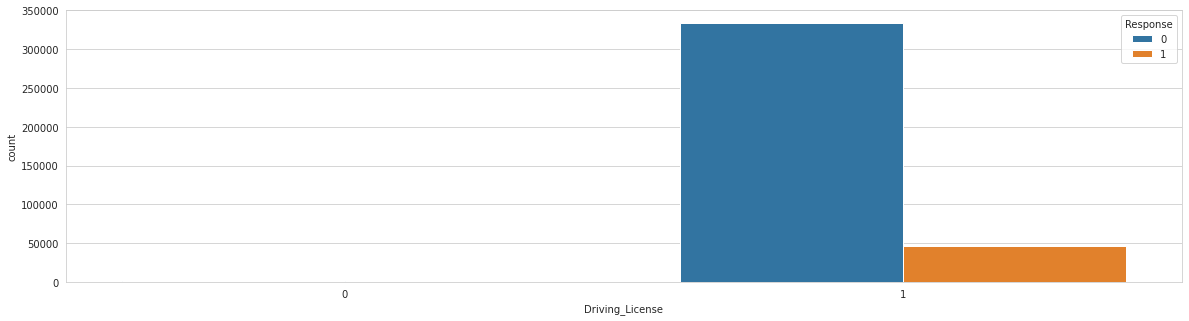

In [13]:
plt.figure(figsize=(20,5))
sns.countplot(x="Driving_License", hue="Response", data=train_df);

Looks like everyone in the dataset has a driver's license!

In [16]:
train_df["Region_Code"].value_counts().head(25)

28.0    106415
8.0      33877
46.0     19749
41.0     18263
15.0     13308
30.0     12191
29.0     11065
50.0     10243
3.0       9251
11.0      9232
36.0      8797
33.0      7654
47.0      7436
35.0      6942
6.0       6280
45.0      5605
37.0      5501
18.0      5153
48.0      4681
14.0      4678
39.0      4644
10.0      4374
21.0      4266
2.0       4038
13.0      4036
Name: Region_Code, dtype: int64

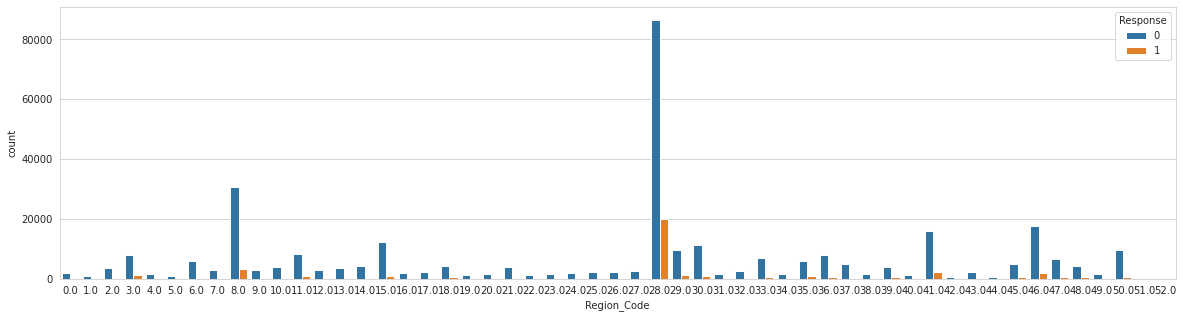

In [17]:
plt.figure(figsize=(20,5))
sns.countplot(x="Region_Code", hue="Response", data=train_df);

We could add a features that flags the most popular regions. Or the ones with the highest proportion of positive response.

In [18]:
train_df["Previously_Insured"].value_counts()

0    206481
1    174628
Name: Previously_Insured, dtype: int64

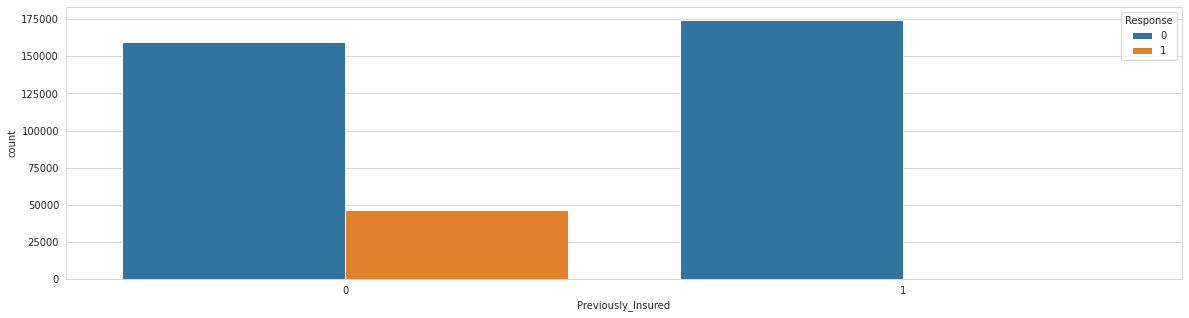

In [19]:
plt.figure(figsize=(20,5))
sns.countplot(x="Previously_Insured", hue="Response", data=train_df);

In [20]:
train_df["Vehicle_Age"].value_counts()

1-2 Year     200316
< 1 Year     164786
> 2 Years     16007
Name: Vehicle_Age, dtype: int64

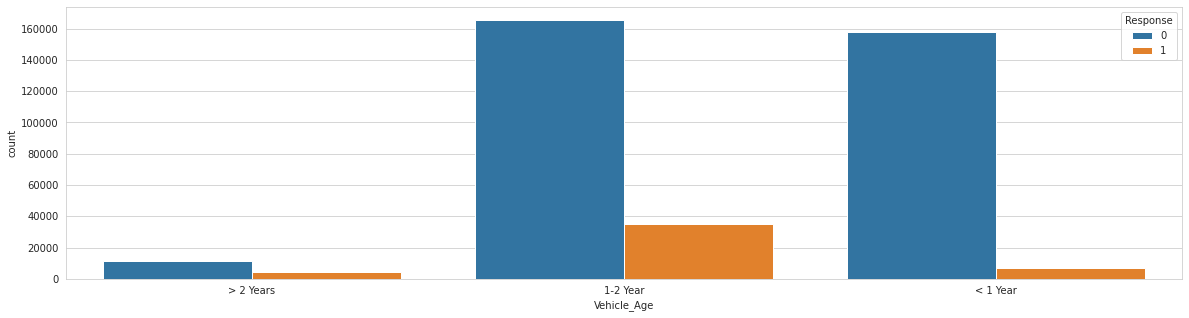

In [21]:
plt.figure(figsize=(20,5))
sns.countplot(x="Vehicle_Age", hue="Response", data=train_df);

Looks like there a much higher proportion of insured cars in 1-2 year category, than in the < 1 year category.

In [22]:
train_df["Vehicle_Damage"].value_counts()

Yes    192413
No     188696
Name: Vehicle_Damage, dtype: int64

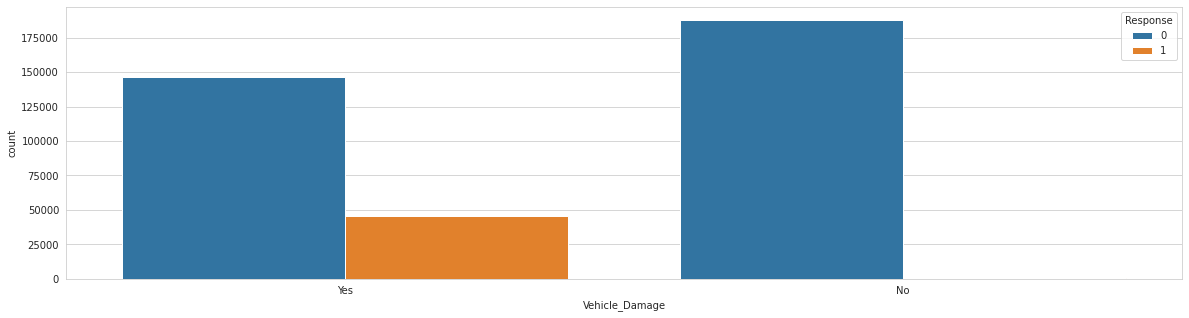

In [23]:
plt.figure(figsize=(20,5))
sns.countplot(x="Vehicle_Damage", hue="Response", data=train_df);

No vehicle damage => no insurance needed!

In [24]:
train_df["Policy_Sales_Channel"].value_counts().head(25)

152.0    134784
26.0      79700
124.0     73995
160.0     21779
156.0     10661
122.0      9930
157.0      6684
154.0      5993
151.0      3885
163.0      2893
13.0       1865
25.0       1848
7.0        1598
8.0        1515
30.0       1410
55.0       1264
155.0      1234
11.0       1203
1.0        1074
52.0       1055
125.0      1026
15.0        888
29.0        843
12.0        783
120.0       769
Name: Policy_Sales_Channel, dtype: int64

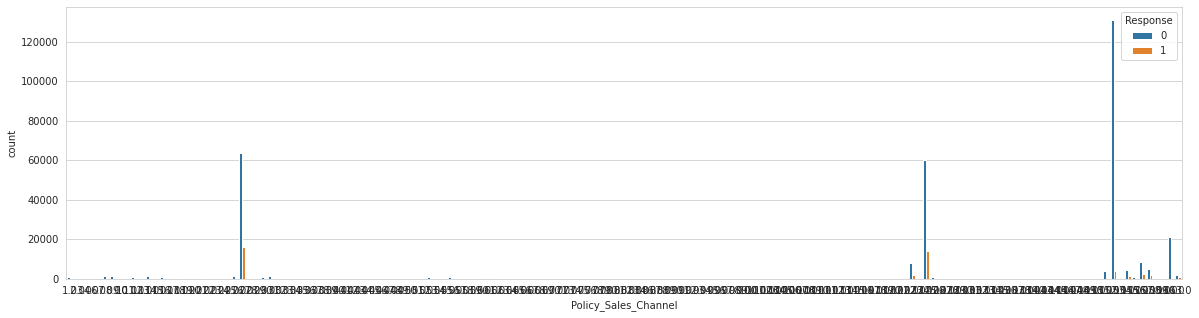

In [25]:
plt.figure(figsize=(20,5))
sns.countplot(x="Policy_Sales_Channel", hue="Response", data=train_df);

### Analysis of continuous variables
Plotted boxplots by target variable and kernel density estimates for each continuous variable to draw interesting insight.

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


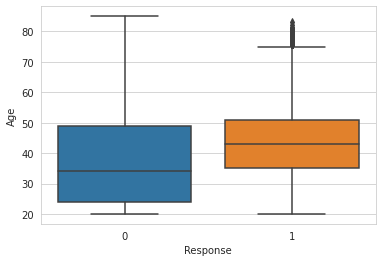

In [26]:
# insured people are older on average by about 7 years
sns.boxplot(train_df["Response"], train_df["Age"]);

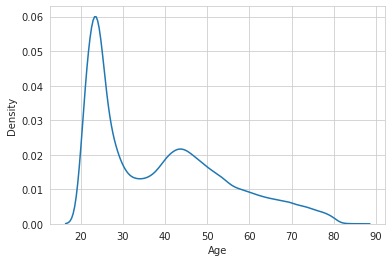

In [27]:
# bimodal distribution of age
sns.kdeplot(train_df["Age"]);

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


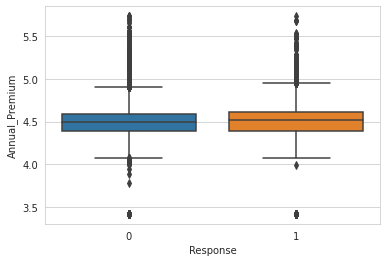

In [28]:
# not much of a difference, lots of outliers even with log-transformation of premium paid
sns.boxplot(train_df["Response"], np.log10(train_df["Annual_Premium"]));

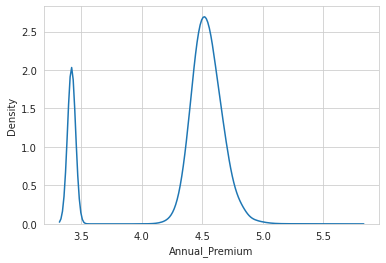

In [29]:
# bimodal distribution of annual premium
sns.kdeplot(np.log10(train_df["Annual_Premium"]));

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


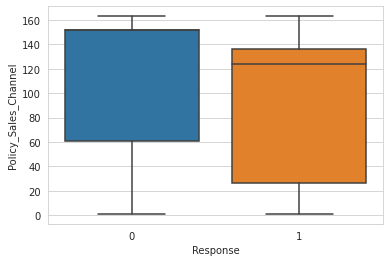

In [43]:
# this does not make much sense, but looking to see if it would be worth it not to encode this variable as continuous
sns.boxplot(train_df["Response"], train_df["Policy_Sales_Channel"]);

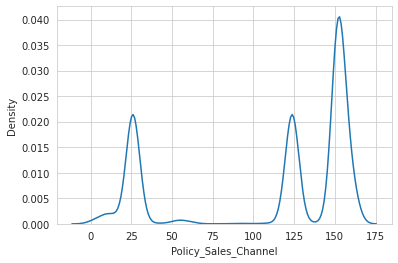

In [44]:
sns.kdeplot(train_df["Policy_Sales_Channel"]);

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


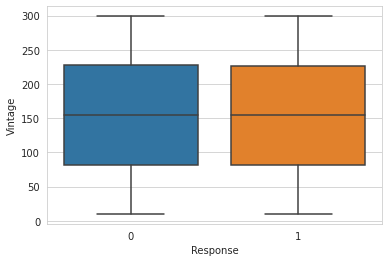

In [45]:
# not much of a difference here
sns.boxplot(train_df["Response"], train_df["Vintage"]);

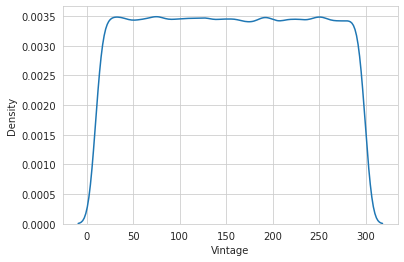

In [46]:
sns.kdeplot(train_df["Vintage"]);

Vintage doesn't seem to have an effect on target variable, Policy Sales Channel, Annual Premium, and Age do.

## Baseline Model
Alright, after basic EDA of all variables, it's time to introduce the basic Catboost model with no tuning as a baseline.

In [30]:
# Data preparation
y = train_df['Response'].values
X = train_df.drop(['Response', 'id'], axis=1)
X.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217
1,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183
2,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27
3,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203
4,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39


In [31]:
# Categorical features declaration
cat_features = ["Gender", "Region_Code", "Previously_Insured", "Vehicle_Age", "Vehicle_Damage", "Policy_Sales_Channel"]
print(cat_features)

['Gender', 'Region_Code', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Policy_Sales_Channel']


In [32]:
# convert to right data types
print(X[cat_features].info())

X_filled = X.copy()
X_filled["Region_Code"] = X["Region_Code"].astype(np.int16)
X_filled["Policy_Sales_Channel"] = X["Policy_Sales_Channel"].astype(np.int16)

X_filled[cat_features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 6 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Gender                381109 non-null  object 
 1   Region_Code           381109 non-null  float64
 2   Previously_Insured    381109 non-null  int64  
 3   Vehicle_Age           381109 non-null  object 
 4   Vehicle_Damage        381109 non-null  object 
 5   Policy_Sales_Channel  381109 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 17.4+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 6 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   Gender                381109 non-null  object
 1   Region_Code           381109 non-null  int16 
 2   Previously_Insured    381109 non-null  int64 
 3   Vehicle_Age           381109 non-nul

In [33]:
# split into training and test sets, shuffle and stratify
from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(X_filled, y, train_size=0.8, random_state=SEED, shuffle=True, stratify=y)

In [34]:
model = CatBoostClassifier(
    random_seed=SEED,    # make code reproducible
    eval_metric='AUC',   # evaluation metric used in the competition, reference here: https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc
    task_type='GPU'      # use GPU to speed up training!
)
model.fit(
    X_train, y_train,                       # input train features and target
    cat_features=cat_features,              # input which variables to treat as categorical
    use_best_model=True,                    # cache best model to use after training is finished
    eval_set=(X_validation, y_validation),  # evaluate on valudation set
    verbose=50                              # print progress every 50th iteration
)
print('Model is fitted: ' + str(model.is_fitted()))
print('Model params:')
print(model.get_params())

Learning rate set to 0.04379
0:	learn: 0.7300705	test: 0.7350620	best: 0.7350620 (0)	total: 55.9ms	remaining: 55.8s
50:	learn: 0.8473518	test: 0.8476181	best: 0.8476181 (50)	total: 2.09s	remaining: 38.9s
100:	learn: 0.8541753	test: 0.8539259	best: 0.8539259 (100)	total: 4.09s	remaining: 36.4s
150:	learn: 0.8565141	test: 0.8558266	best: 0.8558266 (150)	total: 6.01s	remaining: 33.8s
200:	learn: 0.8576283	test: 0.8563952	best: 0.8563952 (200)	total: 7.94s	remaining: 31.6s
250:	learn: 0.8584694	test: 0.8568907	best: 0.8568907 (250)	total: 9.84s	remaining: 29.4s
300:	learn: 0.8591383	test: 0.8572520	best: 0.8572520 (300)	total: 11.8s	remaining: 27.3s
350:	learn: 0.8596287	test: 0.8573664	best: 0.8573697 (349)	total: 13.6s	remaining: 25.2s
400:	learn: 0.8601131	test: 0.8574828	best: 0.8574834 (397)	total: 15.5s	remaining: 23.1s
450:	learn: 0.8605216	test: 0.8576151	best: 0.8576182 (449)	total: 17.3s	remaining: 21.1s
500:	learn: 0.8608967	test: 0.8577058	best: 0.8577085 (498)	total: 19.2s	rem

Model did not improve the last ~150 iterations, which suggests it trained for about the right time, not to over- or underfit.

In [36]:
# how many trees did we grow?
print('Tree count: ' + str(model.tree_count_))

Tree count: 865


In [37]:
# which features were the most beneficial for the model? Helpful for feature engineering (not covered here).
model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,Previously_Insured,58.060342
1,Vehicle_Damage,19.048923
2,Policy_Sales_Channel,8.422820
3,Age,7.547913
4,Region_Code,3.859257
5,Vehicle_Age,2.327715
6,Annual_Premium,0.325198
7,Gender,0.218071
8,Driving_License,0.118190
9,Vintage,0.071571


In [38]:
# prepare data for prediction
X_test = test_df.drop(['id'], axis=1)
X_test.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,Male,25,1,11.0,1,< 1 Year,No,35786.0,152.0,53
1,Male,40,1,28.0,0,1-2 Year,Yes,33762.0,7.0,111
2,Male,47,1,28.0,0,1-2 Year,Yes,40050.0,124.0,199
3,Male,24,1,27.0,1,< 1 Year,Yes,37356.0,152.0,187
4,Male,27,1,28.0,1,< 1 Year,No,59097.0,152.0,297


In [39]:
# convert to right data types in test dataframe
print(X_test[cat_features].info())

X_test_filled = X_test.copy()
X_test_filled["Region_Code"] = X_test["Region_Code"].astype(np.int16)
X_test_filled["Policy_Sales_Channel"] = X_test["Policy_Sales_Channel"].astype(np.int16)

X_test_filled[cat_features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127037 entries, 0 to 127036
Data columns (total 6 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Gender                127037 non-null  object 
 1   Region_Code           127037 non-null  float64
 2   Previously_Insured    127037 non-null  int64  
 3   Vehicle_Age           127037 non-null  object 
 4   Vehicle_Damage        127037 non-null  object 
 5   Policy_Sales_Channel  127037 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 5.8+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127037 entries, 0 to 127036
Data columns (total 6 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   Gender                127037 non-null  object
 1   Region_Code           127037 non-null  int16 
 2   Previously_Insured    127037 non-null  int64 
 3   Vehicle_Age           127037 non-null

In [41]:
# use catboost Pool class to load the dataset, then predict probabilities of `Response` == 1
test_pool = Pool(data=X_test_filled, cat_features=cat_features)
contest_predictions = model.predict_proba(test_pool)[:,1]
print('Predictions:')
print(contest_predictions)

Predictions:
[0.00099469 0.30234474 0.29278176 ... 0.0006389  0.00062148 0.00326372]


In [42]:
# replace sample submission column
submit_df["Response"] = contest_predictions
submit_df.head()

,id,Response
0,381110,0.000995
1,381111,0.302345
2,381112,0.292782
3,381113,0.005886
4,381114,0.000909


In [ ]:
# create a csv to submit to competition!
submit_df.to_csv("Catboost_Baseline.csv", index = False)